# Modèles de fondation pour séries temporelles — TimeXer & co.

Ce notebook implémente **from scratch en PyTorch** plusieurs architectures Transformer modernes pour la prédiction de séries temporelles :

| Modèle | Idée clé |
|---|---|
| **PatchTST** | Découpe la série en *patches* (sous-séquences), chaque patch = un token → Self-Attention |
| **TimeXer** | PatchTST + **Cross-Attention** entre tokens endogènes et tokens exogènes |
| **iTransformer** | *Inverse* : chaque token = une **variable**, pas un pas de temps → capte les corrélations inter-variables |
| **Transformer baseline** | Transformer séquentiel classique (token = pas de temps) |

**Données** : `df_venues_final.csv` — fréquentation journalière (lundi→vendredi)  
**Cible** : `GLOBAL` (nombre de venues)  
**Horizon** : prédiction de la dernière semaine (5 jours) via inférence autorégressive  
**Lookback** : 10 jours (2 semaines ouvrées)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings, math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

# ─────────────────────────────────────────────
#  CONFIG GLOBALE
# ─────────────────────────────────────────────
WINDOW_SIZE  = 10        # lookback : 10 jours (2 semaines ouvrées)
PRED_LEN     = 5         # horizon   : 5 jours (1 semaine ouvrée)
BATCH_SIZE   = 16
EPOCHS       = 200
LR           = 3e-4
D_MODEL      = 64        # dimension interne des Transformers
N_HEADS      = 4         # têtes d'attention
N_LAYERS     = 2         # couches d'encodeur
DROPOUT      = 0.1
PATCH_SIZE   = 2         # taille des patches PatchTST / TimeXer

DEVICE = torch.device('mps' if torch.backends.mps.is_available()
                       else 'cuda' if torch.cuda.is_available()
                       else 'cpu')
print(f'Device : {DEVICE}')
print(f'PyTorch : {torch.__version__}')

Device : mps
PyTorch : 2.10.0


## 1 · Chargement et préparation des données

On trie chronologiquement (Annee → Semaine → jour de semaine) et on normalise **séparément** les features exogènes et la cible `GLOBAL` avec un `StandardScaler`.

- **Features exogènes** (`X_exo`) : toutes les colonnes sauf `GLOBAL` et `Total_reservations`  
- **Série endogène** (`X_endo`) : uniquement `GLOBAL` (la cible à prédire)  

La normalisation est ajustée sur le train et appliquée au test (pas de data leakage).

In [2]:
df = pd.read_csv('../data/df_venues_final.csv', sep=';')

# ── Convertir les booléens textuels en entiers
bool_cols = ['jour_jeudi', 'jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_vendredi']
for col in bool_cols:
    df[col] = df[col].map({'True': 1, 'False': 0}).fillna(df[col]).astype(int)

# ── Numéro de jour (0=lundi … 4=vendredi) pour trier
def get_day_num(row):
    for i, c in enumerate(['jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_jeudi', 'jour_vendredi']):
        if row[c]: return i
    return -1

df['day_num'] = df.apply(get_day_num, axis=1)
df = df.sort_values(['Annee', 'Semaine', 'day_num']).reset_index(drop=True)
df = df[df['day_num'] >= 0].reset_index(drop=True)  # retire les éventuelles lignes sans jour

# ── Colonnes
TARGET_COL  = 'GLOBAL'
DROP_COLS   = ['day_num', 'Total_reservations']   # colonnes utilitaires / cible secondaire
EXO_COLS    = [c for c in df.columns if c not in [TARGET_COL] + DROP_COLS]

# ── Découpage train / test (dernière semaine = test)
n          = len(df)
test_start = n - PRED_LEN          # les 5 derniers jours

train_df = df.iloc[:test_start].reset_index(drop=True)
test_df  = df.iloc[test_start:].reset_index(drop=True)

# ── Normalisation
scaler_endo = StandardScaler()
scaler_exo  = StandardScaler()

train_endo = scaler_endo.fit_transform(train_df[[TARGET_COL]]).flatten()
train_exo  = scaler_exo.fit_transform(train_df[EXO_COLS])

test_endo  = scaler_endo.transform(test_df[[TARGET_COL]]).flatten()
test_exo   = scaler_exo.transform(test_df[EXO_COLS])

# ── Tableau complet (train + test) pour créer les fenêtres
all_endo = np.concatenate([train_endo, test_endo])
all_exo  = np.concatenate([train_exo,  test_exo],  axis=0)

print(f'Total jours       : {n}')
print(f'Train             : {len(train_df)} jours  |  Test : {len(test_df)} jours')
print(f'Features exogènes : {len(EXO_COLS)} → {EXO_COLS}')
print(f'Série endogène    : {TARGET_COL}')

Total jours       : 250
Train             : 245 jours  |  Test : 5 jours
Features exogènes : 15 → ['jour_ferie.', 'pont.conge.', 'holiday', 'Semaine', 'Annee', 'Temp', 'pluie', 'autre', 'Greve_nationale', 'prof_nationale', 'jour_jeudi', 'jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_vendredi']
Série endogène    : GLOBAL


## 2 · Dataset et DataLoader

La classe `TSDataset` crée des fenêtres glissantes :  
- `x_endo` : série GLOBAL des `WINDOW_SIZE` jours précédents → shape `(W,)`  
- `x_exo`  : features exogènes sur la même fenêtre → shape `(W, n_exo)`  
- `y`      : valeur GLOBAL cible (1 jour) → scalaire  

On entraîne **uniquement sur les données train** (pas de fuite du test dans le scaler ni dans les indices).

In [3]:
class TSDataset(Dataset):
    """
    Fenêtres glissantes pour séries temporelles multivariées.

    Paramètres
    ----------
    endo  : np.ndarray (T,)        — série endogène (GLOBAL normalisé)
    exo   : np.ndarray (T, n_exo)  — variables exogènes normalisées
    win   : int                    — taille de la fenêtre lookback
    limit : int | None             — si fourni, on n'utilise que les indices < limit
                                     (évite le data leakage test→train)
    """
    def __init__(self, endo, exo, win, limit=None):
        self.endo  = torch.tensor(endo, dtype=torch.float32)
        self.exo   = torch.tensor(exo,  dtype=torch.float32)
        self.win   = win
        # indices valides : on a besoin de [i-win … i-1] et de la cible i
        max_i = limit if limit is not None else len(endo)
        self.indices = list(range(win, max_i))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        x_endo = self.endo[i - self.win : i]          # (W,)
        x_exo  = self.exo [i - self.win : i]          # (W, n_exo)
        y      = self.endo[i]                          # scalaire
        return x_endo, x_exo, y


# Jeu d'entraînement : seulement les indices dans le train (< test_start)
train_ds = TSDataset(all_endo, all_exo, win=WINDOW_SIZE, limit=test_start)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

N_EXO = all_exo.shape[1]   # nombre de features exogènes

print(f'Échantillons train    : {len(train_ds)}')
print(f'Features exogènes     : {N_EXO}')
print(f'Shape x_endo (batch)  : ({BATCH_SIZE}, {WINDOW_SIZE})')
print(f'Shape x_exo  (batch)  : ({BATCH_SIZE}, {WINDOW_SIZE}, {N_EXO})')

Échantillons train    : 235
Features exogènes     : 15
Shape x_endo (batch)  : (16, 10)
Shape x_exo  (batch)  : (16, 10, 15)


## 3 · Briques communes

### Positional Encoding
Injection d'information de position dans les embeddings via des sinusoïdes (sine/cosine) fixes — identique au Transformer original (Vaswani 2017).

### PatchEmbedding
Découpe la série en sous-séquences de longueur `patch_size` et projette chaque patch dans `d_model` dimensions via une couche linéaire. C'est le cœur de **PatchTST** (Nie et al. 2022).

```
Série (W,) → découpe → (n_patches, patch_size) → Linear → (n_patches, d_model)
```

Avec `W=10`, `patch_size=2` : on obtient **5 tokens** au lieu de 10 → réduit la complexité quadratique de l'attention.

In [4]:
# ══════════════════════════════════════════════════════════
#  BRIQUES COMMUNES
# ══════════════════════════════════════════════════════════

class PositionalEncoding(nn.Module):
    """
    Encodage positionnel sinusoïdal (fixe, non appris).
    Ajoute des informations de position aux tokens.
    """
    def __init__(self, d_model: int, max_len: int = 512, dropout: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)                     # (max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()       # (max_len, 1)
        div = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))            # (1, max_len, d_model)

    def forward(self, x):
        # x : (B, T, d_model)
        return self.dropout(x + self.pe[:, :x.size(1)])


class PatchEmbedding(nn.Module):
    """
    Découpe une série (B, W) en patches et projette dans d_model.
    
    Résultat : (B, n_patches, d_model)
    n_patches = W // patch_size  (on fixe stride = patch_size, pas de chevauchement)
    """
    def __init__(self, window: int, patch_size: int, d_model: int):
        super().__init__()
        assert window % patch_size == 0, "window doit être divisible par patch_size"
        self.patch_size = patch_size
        self.n_patches  = window // patch_size
        self.proj       = nn.Linear(patch_size, d_model)

    def forward(self, x):
        # x : (B, W)
        B, W = x.shape
        x = x.view(B, self.n_patches, self.patch_size)    # (B, n_patches, patch_size)
        return self.proj(x)                                # (B, n_patches, d_model)


class ExoEmbedding(nn.Module):
    """
    Projette les features exogènes (B, W, n_exo) → (B, W, d_model).
    Chaque pas de temps devient un token exogène.
    """
    def __init__(self, n_exo: int, d_model: int):
        super().__init__()
        self.proj = nn.Linear(n_exo, d_model)

    def forward(self, x):
        # x : (B, W, n_exo) → (B, W, d_model)
        return self.proj(x)


# ── Vérification rapide
_pe   = PositionalEncoding(D_MODEL)
_pemb = PatchEmbedding(WINDOW_SIZE, PATCH_SIZE, D_MODEL)
_eemb = ExoEmbedding(N_EXO, D_MODEL)

x_endo_fake = torch.randn(4, WINDOW_SIZE)
x_exo_fake  = torch.randn(4, WINDOW_SIZE, N_EXO)

patches = _pemb(x_endo_fake)
print(f"PatchEmbedding  : (4,{WINDOW_SIZE}) → {tuple(patches.shape)}"
      f"  [{WINDOW_SIZE//PATCH_SIZE} patches de taille {PATCH_SIZE}]")
exo_tok = _eemb(x_exo_fake)
print(f"ExoEmbedding    : (4,{WINDOW_SIZE},{N_EXO}) → {tuple(exo_tok.shape)}")

PatchEmbedding  : (4,10) → (4, 5, 64)  [5 patches de taille 2]
ExoEmbedding    : (4,10,15) → (4, 10, 64)


## 4 · Modèle 1 — PatchTST

**Papier** : Nie et al., *A Time Series is Worth 64 Words* (ICLR 2023)

### Architecture :
```
Série GLOBAL (W,)
      ↓ PatchEmbedding
(n_patches, d_model)  ← chaque patch = un "mot"
      ↓ + PositionalEncoding
      ↓ TransformerEncoder (Self-Attention)
      ↓ Flatten
      ↓ Linear → prédiction scalaire
```

### Avantages :
- La **patchification réduit la séquence** (W=10 → 5 patches) : complexité $O(n^2)$ divisée par 4
- Chaque patch capture la **dynamique locale** 
- N'utilise pas les variables exogènes (baseline univarié)

In [5]:
class PatchTST(nn.Module):
    """
    PatchTST (Nie et al. 2023) — Transformer univarié basé sur des patches.

    Pipeline :
        x_endo (B, W)
        → PatchEmbedding       : (B, n_patches, d_model)
        → + PositionalEncoding
        → TransformerEncoder   : plusieurs couches de Multi-Head Self-Attention
        → Flatten + Linear     : (B,) prédiction scalaire
    """
    def __init__(self, window: int, patch_size: int, d_model: int,
                 n_heads: int, n_layers: int, dropout: float = 0.1):
        super().__init__()
        self.patch_emb = PatchEmbedding(window, patch_size, d_model)
        self.pos_enc   = PositionalEncoding(d_model, dropout=dropout)

        # Un encodeur Transformer standard (Self-Attention uniquement)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout, batch_first=True, norm_first=True  # Pre-LN (plus stable)
        )
        self.encoder   = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        n_patches = window // patch_size
        self.head = nn.Sequential(
            nn.Flatten(),                                  # (B, n_patches * d_model)
            nn.Linear(n_patches * d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1),                        # prédiction scalaire
        )

    def forward(self, x_endo, x_exo=None):               # x_exo ignoré (univarié)
        # x_endo : (B, W)
        tok = self.patch_emb(x_endo)                      # (B, n_patches, d_model)
        tok = self.pos_enc(tok)
        tok = self.encoder(tok)                            # (B, n_patches, d_model)
        return self.head(tok).squeeze(-1)                  # (B,)


# ── Test de forme
_m = PatchTST(WINDOW_SIZE, PATCH_SIZE, D_MODEL, N_HEADS, N_LAYERS, DROPOUT)
_out = _m(x_endo_fake)
print(f"PatchTST  input (4,{WINDOW_SIZE}) → output {tuple(_out.shape)}")
print(f"Paramètres : {sum(p.numel() for p in _m.parameters()):,}")

PatchTST  input (4,10) → output (4,)
Paramètres : 120,769


## 5 · Modèle 2 — TimeXer ★

**Papier** : Chen et al., *TimeXer: Empowering Transformers for Time Series Forecasting with Exogenous Variables* (NeurIPS 2024)

### Idée centrale :
PatchTST est **univarié** — il ignore les variables exogènes (météo, grèves…).  
TimeXer ajoute une **Cross-Attention** qui permet à chaque token endogène (patch) d'interroger les tokens exogènes :

```
x_endo (B, W) ──→ PatchEmbedding ──→ (n_patches, d_model)
                         Self-Attention ↕  ← les patches se "parlent"
x_exo  (B, W, n_exo) → ExoEmbedding → (n_exo_tok, d_model)
                         Cross-Attention ↕  ← les patches "interrogent" les exo.
                         Feed-Forward
                         Linear Head → prédiction
```

### Mécanisme de Cross-Attention :
$$\text{CrossAttn}(Q, K, V) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V$$

- **Q** (Query) = tokens endogènes (patches GLOBAL)  
- **K, V** (Keys & Values) = tokens exogènes (météo, jours, grèves…)  

Les patches peuvent ainsi **pondérer l'importance des variables exogènes** pour affiner leur représentation.

In [6]:
class TimeXerLayer(nn.Module):
    """
    Un bloc TimeXer = Self-Attention endogène + Cross-Attention exogène + FFN.

    Dans chaque bloc :
    1. Self-Attention sur les patches endogènes (les patches GLOBAL se parlent)
    2. Cross-Attention : patches endogènes (Q) ← tokens exogènes (K, V)
    3. Feed-Forward Network
    """
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        # Self-Attention sur les tokens endogènes
        self.self_attn   = nn.MultiheadAttention(d_model, n_heads,
                                                  dropout=dropout, batch_first=True)
        # Cross-Attention : Q = endogène, K = V = exogène
        self.cross_attn  = nn.MultiheadAttention(d_model, n_heads,
                                                  dropout=dropout, batch_first=True)
        # Feed-Forward Network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model),
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop  = nn.Dropout(dropout)

    def forward(self, endo_tok, exo_tok):
        """
        endo_tok : (B, n_patches, d_model) — tokens endogènes
        exo_tok  : (B, T_exo,    d_model) — tokens exogènes
        """
        # 1) Self-Attention (Pre-LayerNorm style)
        h = self.norm1(endo_tok)
        h, _ = self.self_attn(h, h, h)
        endo_tok = endo_tok + self.drop(h)

        # 2) Cross-Attention : Q=endo, K=V=exo
        h = self.norm2(endo_tok)
        h, _ = self.cross_attn(h, exo_tok, exo_tok)
        endo_tok = endo_tok + self.drop(h)

        # 3) FFN
        h = self.norm3(endo_tok)
        endo_tok = endo_tok + self.drop(self.ffn(h))

        return endo_tok


class TimeXer(nn.Module):
    """
    TimeXer complet (Chen et al. 2024).

    Pipeline :
        x_endo (B, W)          → PatchEmbedding + PosEnc → (B, n_patches, d_model)
        x_exo  (B, W, n_exo)   → ExoEmbedding   + PosEnc → (B, W,         d_model)
        → N × TimeXerLayer (Self-Attn + Cross-Attn + FFN)
        → Flatten + Linear Head → (B,)
    """
    def __init__(self, window: int, n_exo: int, patch_size: int,
                 d_model: int, n_heads: int, n_layers: int, dropout: float = 0.1):
        super().__init__()
        # Embeddings
        self.endo_emb  = PatchEmbedding(window, patch_size, d_model)
        self.exo_emb   = ExoEmbedding(n_exo, d_model)
        self.pos_endo  = PositionalEncoding(d_model, dropout=dropout)
        self.pos_exo   = PositionalEncoding(d_model, dropout=dropout)

        # Blocs TimeXer
        self.layers = nn.ModuleList([
            TimeXerLayer(d_model, n_heads, dropout) for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

        n_patches = window // patch_size
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_patches * d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1),
        )

    def forward(self, x_endo, x_exo):
        # x_endo : (B, W)         x_exo : (B, W, n_exo)
        endo_tok = self.pos_endo(self.endo_emb(x_endo))   # (B, n_patches, d_model)
        exo_tok  = self.pos_exo (self.exo_emb (x_exo ))   # (B, W,         d_model)

        for layer in self.layers:
            endo_tok = layer(endo_tok, exo_tok)

        endo_tok = self.norm(endo_tok)
        return self.head(endo_tok).squeeze(-1)             # (B,)


# ── Test de forme
_m = TimeXer(WINDOW_SIZE, N_EXO, PATCH_SIZE, D_MODEL, N_HEADS, N_LAYERS, DROPOUT)
_out = _m(x_endo_fake, x_exo_fake)
print(f"TimeXer   input (4,{WINDOW_SIZE}) + exo (4,{WINDOW_SIZE},{N_EXO}) → output {tuple(_out.shape)}")
print(f"Paramètres : {sum(p.numel() for p in _m.parameters()):,}")

TimeXer   input (4,10) + exo (4,10,15) → output (4,)
Paramètres : 155,457


## 6 · Modèle 3 — iTransformer

**Papier** : Liu et al., *iTransformer: Inverted Transformers Are Effective for Time Series Forecasting* (ICLR 2024)

### Idée "inversée" :
Dans un Transformer classique : **token = pas de temps** (chaque colonne de temps)  
Dans iTransformer : **token = variable** — toute la série temporelle d'une variable = un token

```
Multivarié (B, W, n_vars)  →  transpose  →  (B, n_vars, W)
chaque variable entière  →  Linear(W → d_model)  →  (B, n_vars, d_model)
Self-Attention sur les variables  →  apprend les corrélations inter-variables
Projection  →  prédiction
```

### Pourquoi c'est puissant :
- L'attention capture **quelles variables sont corrélées** (ex: grève ↔ baisse de fréquentation)  
- Chaque token voit **toute la série** temporelle d'une variable  
- Très efficace sur les données multivariées à haute corrélation

In [7]:
class iTransformer(nn.Module):
    """
    iTransformer (Liu et al. 2024) — Transformer "inversé".
    
    Chaque token = une VARIABLE (pas un pas de temps).
    La série temporelle complète de chaque variable est projetée en un vecteur d_model.
    L'attention capture les corrélations entre variables.

    Entrée combinée : on concatène l'endogène (GLOBAL) aux features exogènes.
    → (B, W, 1 + n_exo)  =  (B, W, n_vars)
    Transposé : (B, n_vars, W)
    Embedding : (B, n_vars, d_model)
    """
    def __init__(self, window: int, n_exo: int,
                 d_model: int, n_heads: int, n_layers: int, dropout: float = 0.1):
        super().__init__()
        n_vars = 1 + n_exo                                # endogène + exogènes

        # Chaque variable : Linear(W → d_model)
        self.var_emb = nn.Linear(window, d_model)

        self.pos_enc = PositionalEncoding(d_model, max_len=n_vars + 1, dropout=dropout)

        # Transformer sur les variables (Self-Attention inter-variables)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        # Head : on ne garde que le token de la variable endogène (index 0)
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1),
        )

    def forward(self, x_endo, x_exo):
        # x_endo : (B, W)          x_exo : (B, W, n_exo)
        B, W = x_endo.shape

        # Construire la matrice multivariée : (B, W, n_vars)
        x_mv = torch.cat([x_endo.unsqueeze(-1), x_exo], dim=-1)   # (B, W, n_vars)

        # Inverser : (B, n_vars, W)  puis projeter chaque variable → d_model
        x_mv = x_mv.permute(0, 2, 1)                              # (B, n_vars, W)
        tok  = self.var_emb(x_mv)                                  # (B, n_vars, d_model)
        tok  = self.pos_enc(tok)

        # Self-Attention inter-variables
        tok  = self.encoder(tok)                                   # (B, n_vars, d_model)

        # Prédiction à partir du token endogène uniquement (index 0)
        endo_out = tok[:, 0, :]                                    # (B, d_model)
        return self.head(endo_out).squeeze(-1)                     # (B,)


# ── Test de forme
_m = iTransformer(WINDOW_SIZE, N_EXO, D_MODEL, N_HEADS, N_LAYERS, DROPOUT)
_out = _m(x_endo_fake, x_exo_fake)
print(f"iTransformer input (4,{WINDOW_SIZE}) + exo (4,{WINDOW_SIZE},{N_EXO}) → output {tuple(_out.shape)}")
print(f"Paramètres : {sum(p.numel() for p in _m.parameters()):,}")

iTransformer input (4,10) + exo (4,10,15) → output (4,)
Paramètres : 102,785


## 7 · Modèle 4 — Vanilla Transformer (baseline)

Implémentation classique : chaque **pas de temps** est un token multivarié. Sert de point de comparaison pour mesurer l'apport des innovations architecturales.

```
(B, W, 1 + n_exo) → Linear(1+n_exo → d_model) → (B, W, d_model)
                  → + PositionalEncoding
                  → TransformerEncoder (Self-Attention temporelle)
                  → token final [W-1] → Linear → prédiction
```

In [8]:
class VanillaTransformer(nn.Module):
    """
    Transformer séquentiel classique (Vaswani 2017).
    Token = pas de temps multivarié (GLOBAL + exogènes).
    Chaque token voit le contexte temporel via Self-Attention.
    """
    def __init__(self, window: int, n_exo: int,
                 d_model: int, n_heads: int, n_layers: int, dropout: float = 0.1):
        super().__init__()
        n_vars = 1 + n_exo
        self.input_proj = nn.Linear(n_vars, d_model)
        self.pos_enc    = PositionalEncoding(d_model, dropout=dropout)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        self.head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1),
        )

    def forward(self, x_endo, x_exo):
        # Concaténer endogène + exogène  → (B, W, 1 + n_exo)
        x = torch.cat([x_endo.unsqueeze(-1), x_exo], dim=-1)  # (B, W, n_vars)
        tok = self.input_proj(x)                               # (B, W, d_model)
        tok = self.pos_enc(tok)
        tok = self.encoder(tok)                                 # (B, W, d_model)
        # Utiliser le dernier pas de temps comme représentation globale
        return self.head(tok[:, -1, :]).squeeze(-1)            # (B,)


# ── Test de forme
_m = VanillaTransformer(WINDOW_SIZE, N_EXO, D_MODEL, N_HEADS, N_LAYERS, DROPOUT)
_out = _m(x_endo_fake, x_exo_fake)
print(f"VanillaTransformer → output {tuple(_out.shape)}")
print(f"Paramètres : {sum(p.numel() for p in _m.parameters()):,}")

VanillaTransformer → output (4,)
Paramètres : 103,169


## 8 · Entraînement — boucle commune

On utilise :
- **Optimiseur** : AdamW (Adam + weight decay pour régulariser)  
- **Scheduler** : CosineAnnealingLR — le LR décroît progressivement vers 0  
- **Loss** : MSE (Mean Squared Error) sur les valeurs normalisées  
- **Early stopping** : arrêt si la loss ne s'améliore plus pendant N epochs  

La fonction `train_model` est générique et accepte tous les modèles.

In [9]:
def train_model(model, train_dl, epochs=EPOCHS, lr=LR, patience=30, verbose=True):
    """
    Boucle d'entraînement générique avec early stopping.

    Retourne le modèle entraîné et l'historique des pertes.
    """
    model = model.to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    crit  = nn.MSELoss()

    best_loss = float('inf')
    best_state = None
    no_improve = 0
    history = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for x_endo, x_exo, y in train_dl:
            x_endo, x_exo, y = x_endo.to(DEVICE), x_exo.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            pred = model(x_endo, x_exo)
            loss = crit(pred, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
            opt.step()
            epoch_loss += loss.item()
        sched.step()

        avg_loss = epoch_loss / len(train_dl)
        history.append(avg_loss)

        # Early stopping
        if avg_loss < best_loss - 1e-6:
            best_loss  = avg_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                if verbose:
                    print(f"  Early stopping à l'epoch {epoch}  (best loss={best_loss:.6f})")
                break

        if verbose and epoch % 50 == 0:
            print(f"  Epoch {epoch:4d}/{epochs}  |  Loss : {avg_loss:.6f}")

    # Restaurer les meilleurs poids
    if best_state:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    return model, history


print("Fonction train_model définie ✓")

Fonction train_model définie ✓


## 9 · Inférence autorégressive sur la dernière semaine

**Mode de prédiction** : autorégressive (comme en production)
- Fenêtre initiale = les 10 derniers jours réels avant la semaine de test
- Pour chaque jour de la semaine de test :
  1. Le modèle prédit GLOBAL du jour J
  2. La valeur prédite remplace la valeur réelle dans la fenêtre
  3. La fenêtre glisse d'un jour → on repart au pas 1

⚠️ Pour les features exogènes (météo, jours fériés…) : elles sont **connues à l'avance** (calendaire, prévision météo), donc on utilise les vraies valeurs du test — c'est réaliste.

In [10]:
@torch.no_grad()
def autoregressive_predict(model, all_endo, all_exo, test_start, window, pred_len, device):
    """
    Prédiction autorégressive sur pred_len jours.

    all_endo  : série endogène normalisée complète (train + test)
    all_exo   : features exogènes normalisées complètes
    test_start: premier indice du test dans all_endo
    window    : taille de la fenêtre lookback
    pred_len  : nombre de jours à prédire
    """
    model.eval()

    # Fenêtre initiale (valeurs réelles juste avant le test)
    endo_win = list(all_endo[test_start - window : test_start])   # [W valeurs réelles]
    preds_norm = []

    for step in range(pred_len):
        x_endo = torch.tensor(endo_win, dtype=torch.float32).unsqueeze(0).to(device)   # (1, W)

        # Exogènes du jour courant (dans la fenêtre lookback) — valeurs réelles connues
        exo_win_idx_start = test_start + step - window
        exo_win = all_exo[exo_win_idx_start : test_start + step]      # (W, n_exo)
        x_exo   = torch.tensor(exo_win, dtype=torch.float32).unsqueeze(0).to(device)  # (1, W, n_exo)

        pred_norm = model(x_endo, x_exo).item()
        preds_norm.append(pred_norm)

        # Glissement : on ajoute la valeur prédite (autorégression)
        endo_win.pop(0)
        endo_win.append(pred_norm)

    # Dénormaliser les prédictions
    preds = scaler_endo.inverse_transform(
        np.array(preds_norm).reshape(-1, 1)
    ).flatten()
    actuals = scaler_endo.inverse_transform(
        all_endo[test_start : test_start + pred_len].reshape(-1, 1)
    ).flatten()

    return preds, actuals


def evaluate(model_name, preds, actuals):
    """Calcule et affiche les métriques MAE / MAPE / RMSE."""
    mae  = mean_absolute_error(actuals, preds)
    mape = mean_absolute_percentage_error(actuals, preds) * 100
    rmse = root_mean_squared_error(actuals, preds)
    print(f"  {model_name:<22} | MAE={mae:6.1f}  MAPE={mape:5.1f}%  RMSE={rmse:6.1f}")
    return dict(model=model_name, MAE=mae, MAPE=mape, RMSE=rmse,
                preds=preds, actuals=actuals)


print("Fonctions d'inférence définies ✓")

Fonctions d'inférence définies ✓


## 10 · Entraînement et évaluation comparative

On entraîne les 4 modèles l'un après l'autre et on compare leurs métriques sur la dernière semaine.

In [11]:
results   = []
histories = {}

# ── Dictionnaire des modèles à entraîner ───────────────────────────────────
MODELS = {
    "PatchTST": PatchTST(
        window=WINDOW_SIZE, patch_size=PATCH_SIZE,
        d_model=D_MODEL, n_heads=N_HEADS, n_layers=N_LAYERS, dropout=DROPOUT
    ),
    "TimeXer": TimeXer(
        window=WINDOW_SIZE, n_exo=N_EXO, patch_size=PATCH_SIZE,
        d_model=D_MODEL, n_heads=N_HEADS, n_layers=N_LAYERS, dropout=DROPOUT
    ),
    "iTransformer": iTransformer(
        window=WINDOW_SIZE, n_exo=N_EXO,
        d_model=D_MODEL, n_heads=N_HEADS, n_layers=N_LAYERS, dropout=DROPOUT
    ),
    "VanillaTransformer": VanillaTransformer(
        window=WINDOW_SIZE, n_exo=N_EXO,
        d_model=D_MODEL, n_heads=N_HEADS, n_layers=N_LAYERS, dropout=DROPOUT
    ),
}

# ── Boucle d'entraînement ────────────────────────────────────────────────────
for name, model in MODELS.items():
    print(f"\n{'='*50}")
    print(f" Entraînement : {name}")
    print(f"{'='*50}")
    trained_model, history = train_model(model, train_dl, epochs=EPOCHS,
                                          lr=LR, patience=40, verbose=True)
    histories[name] = history

    preds, actuals = autoregressive_predict(
        trained_model, all_endo, all_exo,
        test_start=test_start, window=WINDOW_SIZE,
        pred_len=PRED_LEN, device=DEVICE
    )
    res = evaluate(name, preds, actuals)
    res['trained'] = trained_model
    results.append(res)

# ── Résumé ───────────────────────────────────────────────────────────────────
print(f"\n{'='*55}")
print(f" RÉSUMÉ COMPARATIF — Semaine {df.iloc[test_start]['Semaine']:.0f} / {df.iloc[test_start]['Annee']:.0f}")
print(f"{'='*55}")
print(f"  {'Modèle':<22} | {'MAE':>6}  {'MAPE':>6}  {'RMSE':>6}")
print(f"  {'-'*50}")
for r in sorted(results, key=lambda x: x['MAE']):
    print(f"  {r['model']:<22} | {r['MAE']:6.1f}  {r['MAPE']:5.1f}%  {r['RMSE']:6.1f}")


 Entraînement : PatchTST
  Epoch   50/200  |  Loss : 0.289889
  Epoch  100/200  |  Loss : 0.129307
  Epoch  150/200  |  Loss : 0.103159
  Epoch  200/200  |  Loss : 0.094203
  PatchTST               | MAE=  53.6  MAPE= 10.1%  RMSE=  65.9

 Entraînement : TimeXer
  Epoch   50/200  |  Loss : 0.127520
  Epoch  100/200  |  Loss : 0.055698
  Epoch  150/200  |  Loss : 0.047090
  Early stopping à l'epoch 153  (best loss=0.039026)
  TimeXer                | MAE=  65.0  MAPE= 12.0%  RMSE=  73.1

 Entraînement : iTransformer
  Epoch   50/200  |  Loss : 0.242727
  Epoch  100/200  |  Loss : 0.111951
  Epoch  150/200  |  Loss : 0.093135
  Epoch  200/200  |  Loss : 0.105674
  iTransformer           | MAE=  27.0  MAPE=  5.0%  RMSE=  32.5

 Entraînement : VanillaTransformer
  Epoch   50/200  |  Loss : 0.156278
  Epoch  100/200  |  Loss : 0.105044
  Epoch  150/200  |  Loss : 0.092166
  Early stopping à l'epoch 158  (best loss=0.059423)
  VanillaTransformer     | MAE=  92.8  MAPE= 15.8%  RMSE=  94.5

 R

## 11 · Visualisations

Trois graphiques :
1. **Prédictions vs Réel** — comparaison jour par jour sur la semaine de test
2. **Courbes de loss** — convergence de chaque modèle
3. **Barplot des métriques** — comparaison MAE/RMSE globale

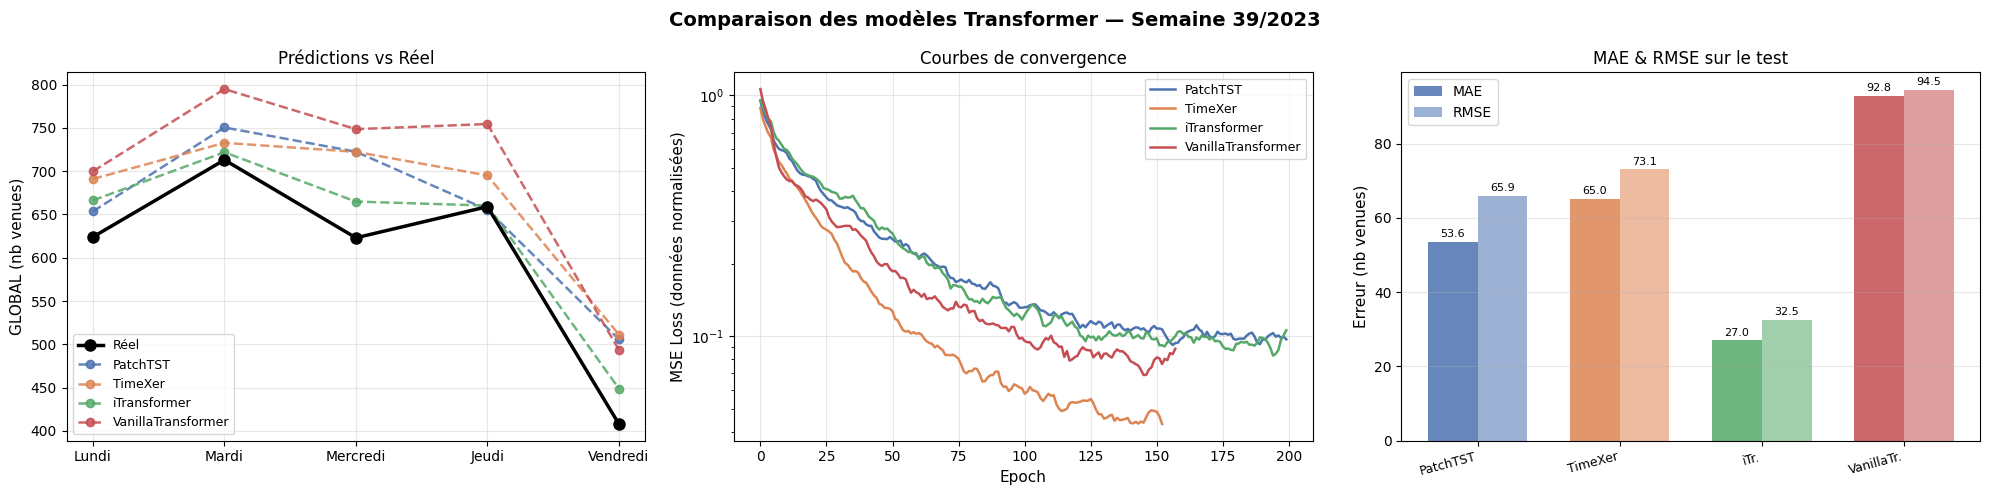

Figure sauvegardée → img/timexer_comparison.png


In [12]:
days = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi']
colors = {'PatchTST': '#4C72B0', 'TimeXer': '#DD8452',
          'iTransformer': '#55A868', 'VanillaTransformer': '#C44E52'}

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(f"Comparaison des modèles Transformer — "
             f"Semaine {df.iloc[test_start]['Semaine']:.0f}/{df.iloc[test_start]['Annee']:.0f}",
             fontsize=14, fontweight='bold')

# ── 1) Prédictions vs Réel ──────────────────────────────────────────────────
ax = axes[0]
actuals = results[0]['actuals']
ax.plot(range(PRED_LEN), actuals, 'ko-', lw=2.5, ms=8, label='Réel', zorder=5)
for r in results:
    ax.plot(range(PRED_LEN), r['preds'], 'o--', lw=1.8, ms=6,
            color=colors[r['model']], label=r['model'], alpha=0.85)
ax.set_xticks(range(PRED_LEN))
ax.set_xticklabels(days, fontsize=10)
ax.set_ylabel('GLOBAL (nb venues)', fontsize=11)
ax.set_title('Prédictions vs Réel', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# ── 2) Courbes de loss ──────────────────────────────────────────────────────
ax = axes[1]
for name, hist in histories.items():
    smooth = pd.Series(hist).rolling(5, min_periods=1).mean()
    ax.plot(smooth, lw=1.8, color=colors[name], label=name)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('MSE Loss (données normalisées)', fontsize=11)
ax.set_title('Courbes de convergence', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# ── 3) Barplot MAE & RMSE ───────────────────────────────────────────────────
ax = axes[2]
model_names = [r['model'].replace('Transformer', 'Tr.') for r in results]
maes  = [r['MAE']  for r in results]
rmses = [r['RMSE'] for r in results]
x = np.arange(len(model_names))
w = 0.35
b1 = ax.bar(x - w/2, maes,  w, label='MAE',  alpha=0.85,
            color=[colors[r['model']] for r in results])
b2 = ax.bar(x + w/2, rmses, w, label='RMSE', alpha=0.55,
            color=[colors[r['model']] for r in results])
ax.bar_label(b1, fmt='%.1f', fontsize=8, padding=2)
ax.bar_label(b2, fmt='%.1f', fontsize=8, padding=2)
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=9, rotation=15, ha='right')
ax.set_ylabel('Erreur (nb venues)', fontsize=11)
ax.set_title('MAE & RMSE sur le test', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../img/timexer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure sauvegardée → img/timexer_comparison.png")

## 12 · Tableau détaillé jour par jour

In [13]:
actuals = results[0]['actuals']

print(f"\n{'Jour':<10} {'Réel':>8}", end='')
for r in results:
    short = r['model'].replace('Transformer', 'Tr.').replace('Vanilla', 'Van.')
    print(f"  {short:>17}", end='')
print()
print('─' * (10 + 8 + len(results) * 19))

for j, day in enumerate(days):
    print(f"{day:<10} {actuals[j]:>8.0f}", end='')
    for r in results:
        pred = r['preds'][j]
        err  = pred - actuals[j]
        sign = '+' if err >= 0 else ''
        print(f"  {pred:>8.0f} ({sign}{err:.0f})", end='')
    print()

# Affichage pandas pour une belle table HTML dans Jupyter
rows = []
for j, day in enumerate(days):
    row = {'Jour': day, 'Réel': int(actuals[j])}
    for r in results:
        row[r['model']] = f"{r['preds'][j]:.0f} ({r['preds'][j]-actuals[j]:+.0f})"
    rows.append(row)

detail_df = pd.DataFrame(rows).set_index('Jour')
detail_df


Jour           Réel           PatchTST            TimeXer               iTr.            Van.Tr.
──────────────────────────────────────────────────────────────────────────────────────────────
Lundi           624       654 (+30)       691 (+67)       666 (+42)       700 (+76)
Mardi           713       750 (+37)       733 (+20)       722 (+9)       795 (+82)
Mercredi        623       722 (+99)       722 (+99)       665 (+42)       748 (+125)
Jeudi           659       655 (-4)       695 (+36)       660 (+1)       754 (+95)
Vendredi        408       506 (+98)       511 (+103)       449 (+41)       494 (+86)


,Réel,PatchTST,TimeXer,iTransformer,VanillaTransformer
Jour,,,,,
Lundi,624,654 (+30),691 (+67),666 (+42),700 (+76)
Mardi,713,750 (+37),733 (+20),722 (+9),795 (+82)
Mercredi,623,722 (+99),722 (+99),665 (+42),748 (+125)
Jeudi,659,655 (-4),695 (+36),660 (+1),754 (+95)
Vendredi,408,506 (+98),511 (+103),449 (+41),494 (+86)


## 13 · Analyse des poids d'attention TimeXer (interprétabilité)

On visualise les poids de **Cross-Attention** du premier bloc TimeXer : pour chaque patch endogène, quelle importance accorde-t-il aux différents pas de temps exogènes ? C'est ce qui rend TimeXer interprétable.

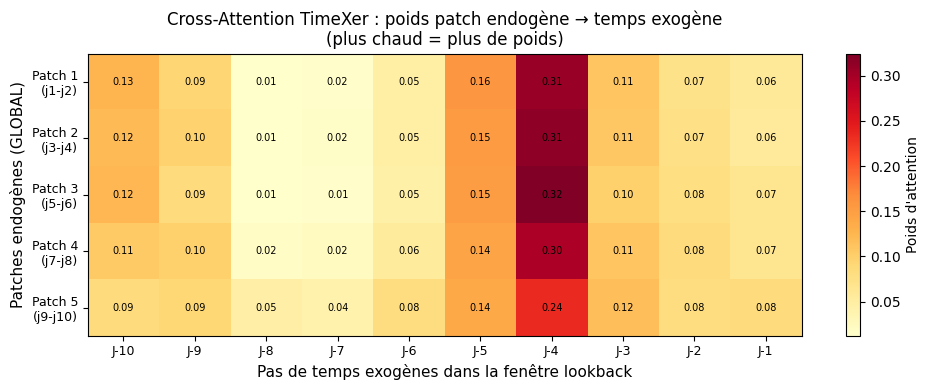

In [14]:
# Récupérer le modèle TimeXer entraîné
timexer_model = next(r['trained'] for r in results if r['model'] == 'TimeXer')
timexer_model.eval()

# ── Hook sur le premier bloc TimeXer pour capturer les poids de cross-attention
attn_weights = {}

def hook_fn(module, input, output):
    # MultiheadAttention retourne (output, attn_weights) si need_weights=True
    # On doit forcer need_weights dans le forward — on réimplémente l'appel
    pass

# Appel manuel avec need_weights=True sur le premier layer
with torch.no_grad():
    # Construire l'entrée de test (premier jour de la semaine de test)
    endo_win = all_endo[test_start - WINDOW_SIZE : test_start]
    exo_win  = all_exo [test_start - WINDOW_SIZE : test_start]

    x_endo = torch.tensor(endo_win, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    x_exo  = torch.tensor(exo_win,  dtype=torch.float32).unsqueeze(0).to(DEVICE)

    # Embeddings
    endo_tok = timexer_model.pos_endo(timexer_model.endo_emb(x_endo))   # (1, n_patches, d_model)
    exo_tok  = timexer_model.pos_exo (timexer_model.exo_emb (x_exo ))   # (1, W, d_model)

    # Cross-Attention du layer 0 avec poids
    layer0 = timexer_model.layers[0]
    h_norm = layer0.norm2(endo_tok)
    _, cross_attn_w = layer0.cross_attn(
        h_norm, exo_tok, exo_tok,
        need_weights=True, average_attn_weights=True
    )
    # cross_attn_w : (1, n_patches, W)  →  moyenne sur les têtes
    attn_map = cross_attn_w.squeeze(0).cpu().numpy()   # (n_patches, W)

n_patches = WINDOW_SIZE // PATCH_SIZE
patch_labels = [f"Patch {i+1}\n(j{i*PATCH_SIZE+1}-j{(i+1)*PATCH_SIZE})" for i in range(n_patches)]
time_labels  = [f"J-{WINDOW_SIZE-i}" for i in range(WINDOW_SIZE)]

fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(attn_map, aspect='auto', cmap='YlOrRd')
ax.set_xticks(range(WINDOW_SIZE))
ax.set_xticklabels(time_labels, fontsize=9)
ax.set_yticks(range(n_patches))
ax.set_yticklabels(patch_labels, fontsize=9)
ax.set_xlabel('Pas de temps exogènes dans la fenêtre lookback', fontsize=11)
ax.set_ylabel('Patches endogènes (GLOBAL)', fontsize=11)
ax.set_title('Cross-Attention TimeXer : poids patch endogène → temps exogène\n'
             '(plus chaud = plus de poids)', fontsize=12)
plt.colorbar(im, ax=ax, label='Poids d\'attention')
# Annoter les valeurs
for pi in range(n_patches):
    for ti in range(WINDOW_SIZE):
        ax.text(ti, pi, f'{attn_map[pi, ti]:.2f}', ha='center', va='center',
                fontsize=7, color='black' if attn_map[pi, ti] < 0.5 else 'white')
plt.tight_layout()
plt.savefig('../img/timexer_attention.png', dpi=150, bbox_inches='tight')
plt.show()